<a href="https://colab.research.google.com/github/Emd956/101_Food_Classes_Fine_Tuning_Project/blob/main/07_project1_101_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## Check GPU

* Google Colab offers free GPUs (thank you Google), however, not all of them are compatible with mixed precision training.

Googla Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

In [2]:
# !pip install tensorflow==2.4.1

In [3]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4d1de4cb-e0c3-576a-502e-e062a0c194e2)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

The script got available can be found on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [5]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-06 21:05:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-06 21:05:31 (89.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [7]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [8]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [9]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, #data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.H55KVZ_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.H55KVZ_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [10]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [13]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 289, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 45
  Class name (str form): frozen_yogurt
  


In [15]:
# What does our image tensor from TFDS's look like?
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [16]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

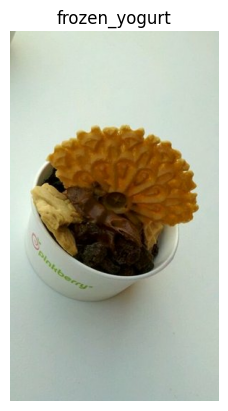

In [17]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural Networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know abour our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few thing we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions need to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224, scale=False):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image

  if scale:
    image /= 255. # scale image values to [0, 1] (not required with EfficientNetBX models from tf.keras.applications)

  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image=image, label=label, img_shape=224)[0]
print(f"Image before preprocessing:\n{image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
[[[145 151 125]
  [157 163 137]
  [159 165 139]
  ...
  [197 209 199]
  [197 209 199]
  [197 207 198]]

 [[146 152 126]
  [156 162 136]
  [158 164 138]
  ...
  [197 209 199]
  [197 209 199]
  [199 209 200]]]...,
Shape: (512, 289, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[147.19739 153.19739 127.19739]
  [157.22768 163.22768 137.22768]
  [158.09805 164.09805 138.09805]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [198.09914 208.38936 199.24425]]

 [[154.69467 160.69467 134.69467]
  [155.87053 161.87053 135.87053]
  [158.39908 164.39908 138.39908]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [196.32831 206.61853 195.76364]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resource on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [20]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, Tensorflow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize it later if need be)
* ModelCheckpoint callback to sabe our model's progress after feature extraction

In [22]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision trianing, check out the TensorFlow guide for mixed precision:
https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note. EfficientNet models have rescaling built-in but if your model doesn't you can have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [27]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variables in
* `layer.dtype_policy`: the datatype policy a layer computes on its variables with

In [28]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [29]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240806-212811
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 334s 124ms/step - accuracy: 0.4346 - loss: 2.4576 - val_accuracy: 0.6555 - val_loss: 1.3064
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6544 - val_loss: 1.3132
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 269s 90ms/step - accuracy: 0.6283 - loss: 1.4493 - val_accuracy: 0.6809 - val_loss: 1.1790


In [30]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.6828 - loss: 1.1910


[1.1848682165145874, 0.6845940351486206]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

You can find the TEMPLATE notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get stuck, you can refer to the example version (none-template): https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb



## Fine-Tune our model for better results

In [39]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d True
dense True
softmax_float32 True


In [40]:
# Let's fine-tuning our model
model.layers[1].trainable = True

for layer in model.layers[1].layers[:-10]:
  layer.trainable = False

In [41]:
# Check trainable layers
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [42]:
# Recompile model with lower learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [44]:
# Fine-tune for 3 more epochs
fine_tune_epochs = 6

# Fine-tune our model
history_101_food_classes_fine_tune = model.fit(train_data,
                                               steps_per_epoch=len(train_data),
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.15 * len(test_data)),
                                               initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_fine_tune"),
                                                          model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20240806-214542
Epoch 3/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 231s 97ms/step - accuracy: 0.6708 - loss: 1.2925 - val_accuracy: 0.7248 - val_loss: 1.0197
Epoch 4/6


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7140 - val_loss: 1.0516
Epoch 5/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 211s 78ms/step - accuracy: 0.7163 - loss: 1.0826 - val_accuracy: 0.7254 - val_loss: 0.9764
Epoch 6/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7415 - val_loss: 0.9612


In [45]:
# Evaluate on the whole test data
results_fine_tune_model = model.evaluate(test_data)
results_fine_tune_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.7279 - loss: 0.9904


[0.9825372099876404, 0.7295841574668884]

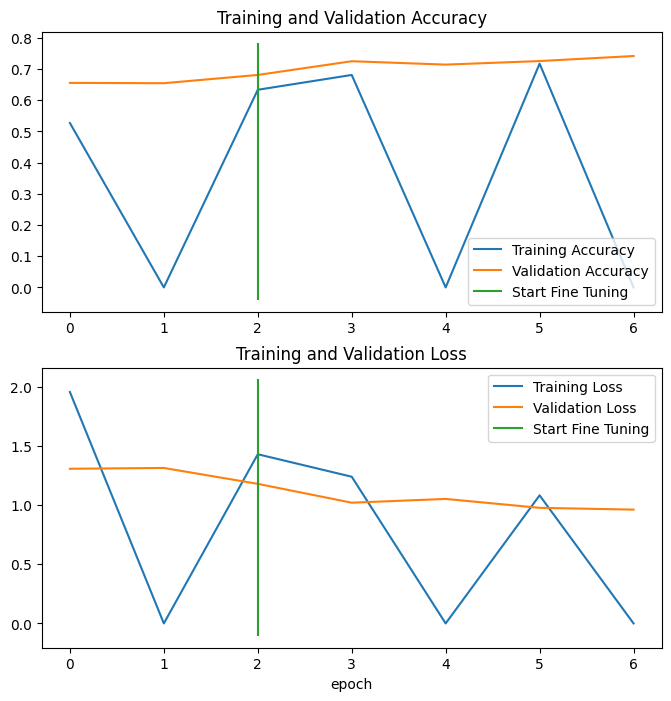

In [46]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_fine_tune,
                 initial_epochs=3)

In [47]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Colab Notebooks/TensorFlow ZTM/101_food_classes_all_data_fine_tune_model.keras")

In [48]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TensorFlow ZTM/101_food_classes_all_data_fine_tune_model.keras")
loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 72ms/step - accuracy: 0.7254 - loss: 0.9937


[0.9883407354354858, 0.7278415560722351]

In [49]:
# Make predictions with our model
pred_probs = loaded_model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 77s 89ms/step


In [50]:
# Get the pred_classes of each label
pred_classes = tf.argmax(pred_probs, axis=1)
pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([44, 37, 35, 40, 60,  1, 69, 92, 62, 50])>

In [51]:
len(pred_classes)

25250

In [52]:
# Unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [53]:
len(y_labels)

25250

In [77]:
# Create a function to load and prepare images
def load_and_prep_image(image, img_shape=224, scale=True):
  """
  Reads in an image from image, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    image (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Resize the image
  img = tf.image.resize(image, size=[img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


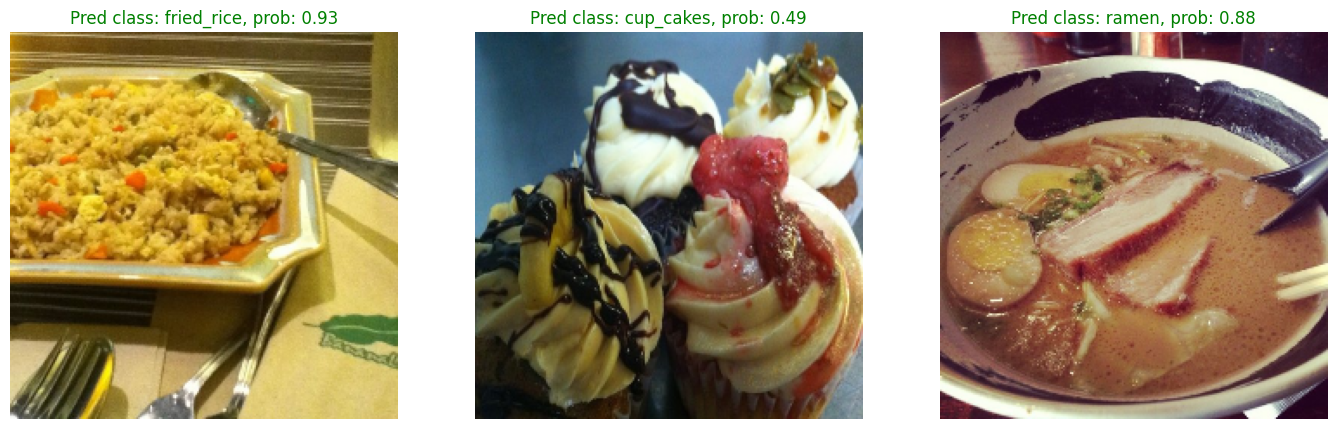

In [80]:
# Make preds on a series of random images
import os
import random

# Unravel our test_data BatchDataset
y_labels = []
y_images = []
i = 0
for images, labels in test_data.unbatch():
  if i==3:
    break
  i += 1
  y_labels.append(labels.numpy().argmax())
  y_images.append(images.numpy())

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random images from random class(es)
  class_name = class_names[y_labels[i]]
  image = y_images[i]

  # Load the image and make predictions
  img = load_and_prep_image(image, scale=False)
  img_expanded = tf.expand_dims(img, axis=0) # expand image dimensions to make it batch size 1
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_name list
  # print(pred_prob)
  # print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "g"
  plt.title(f"Pred class: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);